In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSA_features.csv')
df.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [4]:
# 정상 및 비정상 데이터 설정
# 'lyingBack', 'lyingRight'를 정상(normal), 'sitting'을 비정상(abnormal)으로 설정
df_filtered = df[df['activity'].isin(['lyingBack', 'lyingRigh', 'sitting'])]
df_filtered['label'] = df_filtered['activity'].apply(lambda x: 'normal' if x in ['lyingBack', 'lyingRigh'] else 'abnormal')

<ipython-input-4-04347fa42395>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['activity'].apply(lambda x: 'normal' if x in ['lyingBack', 'lyingRigh'] else 'abnormal')


In [5]:
# 특성과 레이블 데이터를 준비합니다. 범주형 변수는 더미 변수로 변환
x_data = pd.get_dummies(df_filtered.drop(columns=['activity', 'label'])).values.astype('float32')
y_data = df_filtered['label'].values

In [6]:
# 데이터를 학습용과 테스트용으로 분할
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
# 정상 데이터만 추출하여 학습에 사용
train_x_normal = train_x[train_y == 'normal']

In [7]:
# 데이터를 정규화하여 학습 성능을 향상
scaler = StandardScaler()
train_x_normal = scaler.fit_transform(train_x_normal)
test_x = scaler.transform(test_x)

In [8]:
# 오토인코더 모델 설정 (대칭형 오토인코더)
# 입력 차원과 인코딩 차원을 정의
input_dim = train_x_normal.shape[1]
encoding_dim = 14

In [9]:
# 인코딩 및 디코딩 레이어를 설정
input_layer = Input(shape=(input_dim,))
# 첫 번째 인코딩 레이어를 정의. 입력 데이터를 'encoding_dim' 크기의 은닉층으로 압축하고 ReLU 활성화 함수를 사용
encoded = Dense(encoding_dim, activation='relu')(input_layer)
# 두 번째 인코딩 레이어를 정의하여 차원을 절반으로 줄임. 'encoding_dim / 2' 크기의 은닉층을 생성하고 ReLU 활성화 함수를 사용
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
# 첫 번째 디코딩 레이어를 정의하여 인코딩된 표현의 차원을 복구하기 시작. 'encoding_dim / 2' 크기의 은닉층을 생성하고 ReLU 활성화 함수를 사용
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
# 출력 레이어를 정의하여 원래의 입력 차원으로 복원. 시그모이드 활성화 함수를 사용하여 출력값을 0과 1 사이로 제
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 오토인코더 모델을 생성하고 컴파일
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [10]:
# 오토인코더를 학습
history = autoencoder.fit(train_x_normal, train_x_normal,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1645 - val_loss: 1.8171
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5206 - val_loss: 1.7778
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2179 - val_loss: 1.6847
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8927 - val_loss: 1.5876
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6959 - val_loss: 1.5366
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8907 - val_loss: 1.5176
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6652 - val_loss: 1.5099
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6874 - val_loss: 1.5044
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0151 - val_loss: 1.5009
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7029 - val_loss: 1.4987
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9638 - val_loss: 1.4950
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9694 - val_l

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


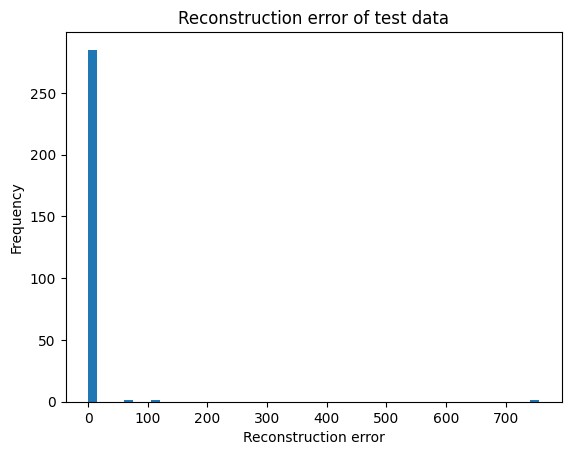

In [11]:
# 테스트 데이터를 오토인코더로 재구성하고 재구성 오차를 계산
# 테스트 데이터를 오토인코더를 통해 재구성하고, 원본 데이터와의 차이(재구성 오차)를 계산하여 이상 탐지를 수행
reconstructed = autoencoder.predict(test_x)
reconstruction_error = np.mean(np.power(test_x - reconstructed, 2), axis=1)

plt.hist(reconstruction_error, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.title('Reconstruction error of test data')
plt.show()

In [12]:
# 재구성 오차를 기준으로 정상과 비정상을 분류하기 위한 임계값을 설정
# 재구성 오차의 67번째 백분위수를 임계값으로 설정하여 이를 기준으로 정상/비정상을 구분
threshold = np.percentile(reconstruction_error, 67)

In [13]:
# 임계값을 기준으로 테스트 데이터를 정상/비정상으로 예측
# 재구성 오차가 임계값보다 큰 경우 '비정상'으로, 그렇지 않은 경우 '정상'으로 예측
y_pred = ['abnormal' if error > threshold else 'normal' for error in reconstruction_error]

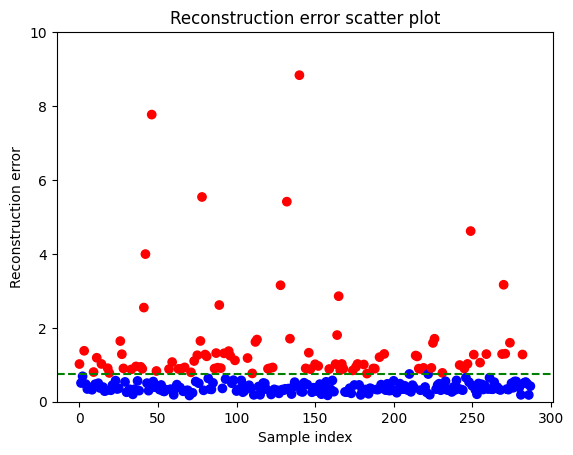

In [14]:
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=['red' if error > threshold else 'blue' for error in reconstruction_error])
plt.ylim([0, 10])  # y축 범위를 0에서 50으로 설정하여 대부분의 데이터를 더 잘 보이게 함
plt.axhline(y=threshold, color='green', linestyle='--')
plt.xlabel('Sample index')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error scatter plot')
plt.show()

In [15]:
# 재구성 오차와 실제 레이블을 데이터프레임으로 만듬
# 재구성 오차와 실제 레이블(정상: 0, 비정상: 1)을 포함한 데이터프레임을 생성하여 평가에 사용
error_df = pd.DataFrame({'reconstruction_error': reconstruction_error, 'true_class': [1 if label == 'abnormal' else 0 for label in test_y]})

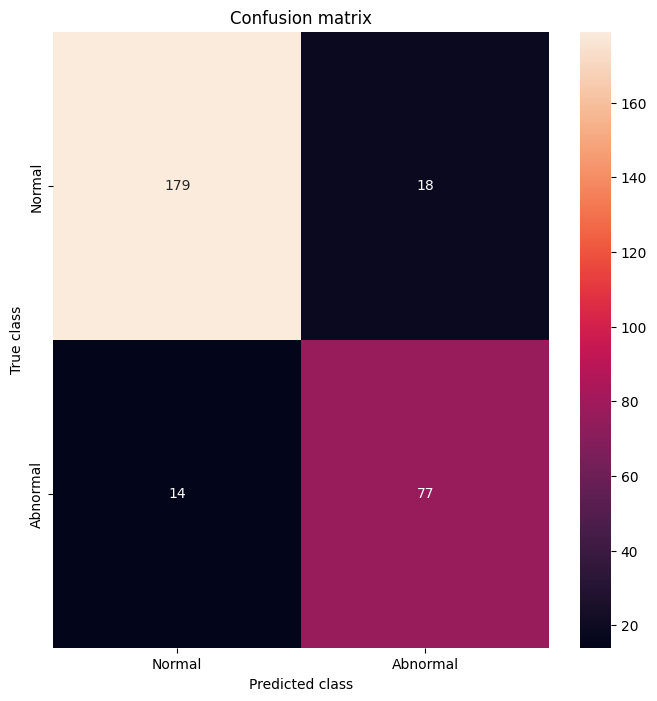

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       197
           1       0.81      0.85      0.83        91

    accuracy                           0.89       288
   macro avg       0.87      0.88      0.87       288
weighted avg       0.89      0.89      0.89       288



In [16]:
y_pred_binary = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_binary)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred_binary))

In [17]:
# 비대칭형 오토인코더 설정 (인코딩과 디코딩의 구조가 다름)
# 인코딩 및 디코딩 레이어의 크기를 다르게 설정하여 비대칭형 오토인코더를 정의
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 4), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

asymmetric_autoencoder = Model(inputs=input_layer, outputs=decoded)
asymmetric_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [18]:
# 비대칭형 오토인코더 모델을 생성하고 컴파일
# 입력 레이어와 출력 레이어를 연결하여 비대칭형 오토인코더 모델을 생성
history = autoencoder.fit(train_x_normal, train_x_normal,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8141 - val_loss: 1.3965
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6827 - val_loss: 1.3969
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7148 - val_loss: 1.3961
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5523 - val_loss: 1.3960
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5561 - val_loss: 1.3959
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6140 - val_loss: 1.3955
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6496 - val_loss: 1.3953
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8063 - val_loss: 1.3952
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5731 - val_loss: 1.3950
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5765 - val_loss: 1.3951
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5503 - val_loss: 1.3948
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9233 - val_lo

In [19]:
# 테스트 데이터를 비대칭형 오토인코더를 통해 재구성하고, 재구성 오차를 계산
reconstructed = autoencoder.predict(test_x)
reconstruction_error = np.mean(np.power(test_x - reconstructed, 2), axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [20]:
# 재구성 오차와 실제 클래스 레이블을 포함한 데이터프레임을 생성
error_df = pd.DataFrame({'reconstruction_error': reconstruction_error, 'true_class': [1 if label == 'abnormal' else 0 for label in test_y]})

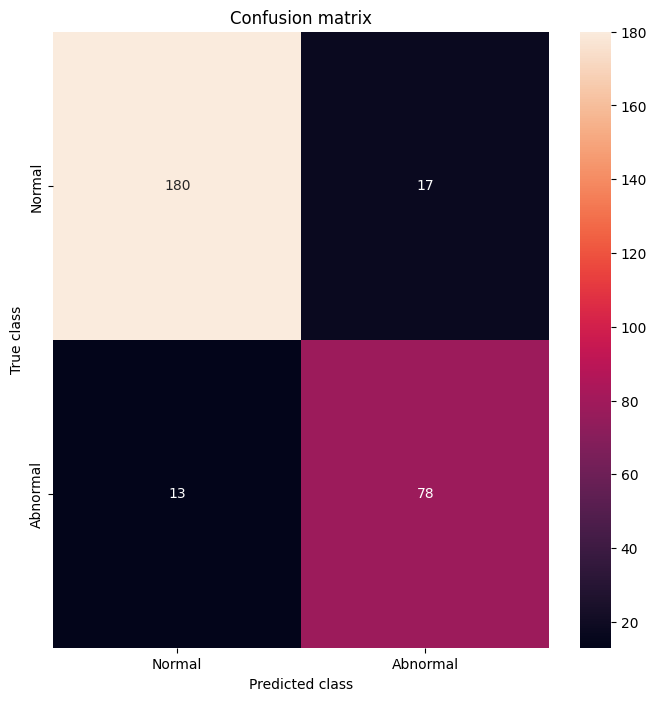

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       197
           1       0.82      0.86      0.84        91

    accuracy                           0.90       288
   macro avg       0.88      0.89      0.88       288
weighted avg       0.90      0.90      0.90       288



In [21]:
y_pred_binary = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_binary)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred_binary))

In [22]:
# Denoising Autoencoder 설정
# 데이터를 노이즈가 추가된 버전으로 만들어 학습
# 원본 데이터를 사용하여 노이즈가 추가된 데이터를 생성하고 이를 통해 오토인코더를 학습함으로써 잡음을 제거하는 기능을 학습
np.random.seed(42)
data_size = 1000
original_data = np.sin(np.linspace(0, 2 * np.pi, data_size))

In [23]:
# 원본 데이터에 노이즈를 추가하여 노이즈 제거(autoencoding)의 학습 데이터를 생성
noise_factor = 0.2
noisy_train_x = train_x_normal + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x_normal.shape)

In [24]:
# DAE 모델 설정
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# DAE 모델을 생성하고 컴파일
# 노이즈가 있는 데이터를 정제하기 위한 오토인코더 모델을 생성
dae = Model(inputs=input_layer, outputs=decoded)
dae.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# 노이즈가 추가된 데이터를 사용하여 DAE 모델을 학습
dae.fit(noisy_train_x, train_x_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9713 - val_loss: 1.7826
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1026 - val_loss: 1.7086
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9621 - val_loss: 1.6191
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9582 - val_loss: 1.5496
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7669 - val_loss: 1.5098
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7479 - val_loss: 1.4870
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6283 - val_loss: 1.4714
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6301 - val_loss: 1.4586
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7001 - val_loss: 1.4471
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6664 - val_loss: 1.4364
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4913 - val_loss: 1.4282
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9876 - val_l

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


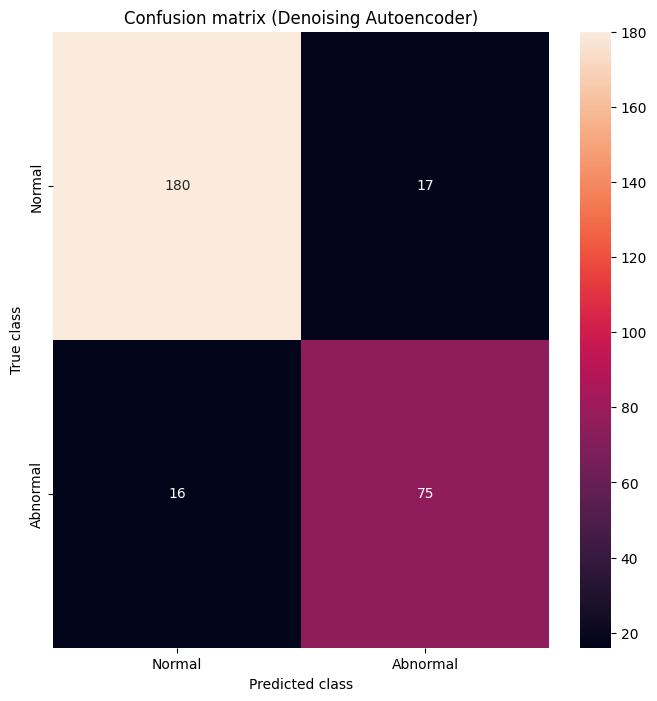

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       197
           1       0.82      0.82      0.82        91

    accuracy                           0.89       288
   macro avg       0.87      0.87      0.87       288
weighted avg       0.89      0.89      0.89       288



In [26]:
reconstructed = dae.predict(test_x)
reconstruction_error = np.mean(np.power(test_x - reconstructed, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': reconstruction_error, 'true_class': [1 if label == 'abnormal' else 0 for label in test_y]})
y_pred_binary = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_binary)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'], annot=True, fmt="d")
plt.title("Confusion matrix (Denoising Autoencoder)")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred_binary))